### Creating Validation, Testing and Training Sets

In [1]:
from sklearn.model_selection import train_test_split
import os
import shutil  # For file moving 

# Define paths to your data directory and subfolders containing class labels (e.g., glaucoma, cataract, etc.)
data_dir = "dataset/"  # Replace with your actual data directory path

# Get a list of class labels (subfolder names)
classes = os.listdir(data_dir)

# Loop through each class label directory
for c in classes:
  # Get all image paths within the class directory
  image_paths = [os.path.join(data_dir, c, f) for f in os.listdir(os.path.join(data_dir, c))]

  # Split the image paths into training, validation, and testing sets using train_test_split
  train_val_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)  # Adjust test_size as needed
  train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2, random_state=42)  # Further split for validation

  # Create the destination folders (if they don't exist)
  os.makedirs(os.path.join(data_dir, "train", c), exist_ok=True)
  os.makedirs(os.path.join(data_dir, "validation", c), exist_ok=True)
  os.makedirs(os.path.join(data_dir, "test", c), exist_ok=True)

  # Move images to respective folders based on the split paths
  for image_path in train_paths:
    shutil.move(image_path, os.path.join(data_dir, "train", c, os.path.basename(image_path)))

  for image_path in val_paths:
    shutil.move(image_path, os.path.join(data_dir, "validation", c, os.path.basename(image_path)))

  for image_path in test_paths:
    shutil.move(image_path, os.path.join(data_dir, "test", c, os.path.basename(image_path)))

print("Data split completed! Folders are created in 'dataset'")

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Preprocessing The Images

Found 2697 images belonging to 4 classes.
Found 675 images belonging to 4 classes.
Train data shape: (32, 224, 224, 3)
Train labels shape: (32, 4)
Validation data shape: (32, 224, 224, 3)
Validation labels shape: (32, 4)
First few training images: [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]


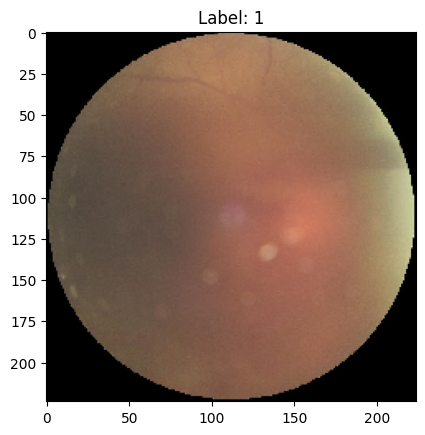

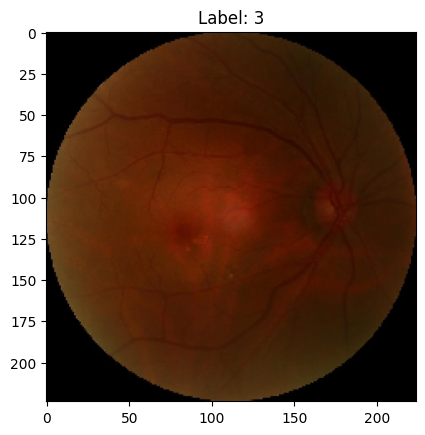

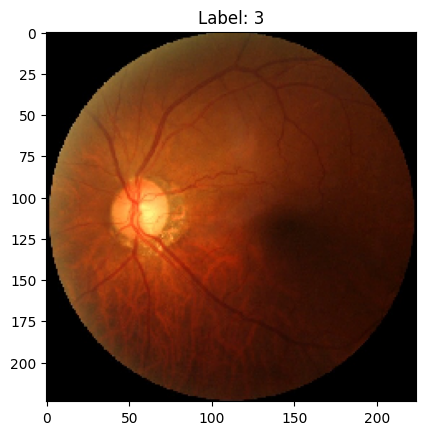

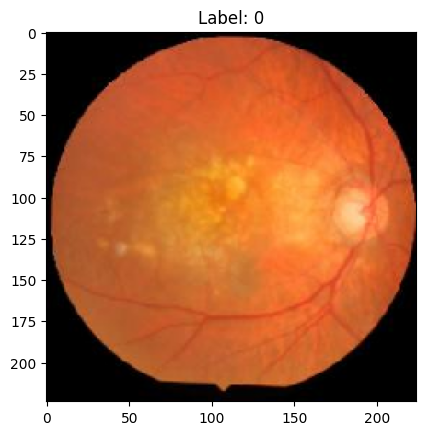

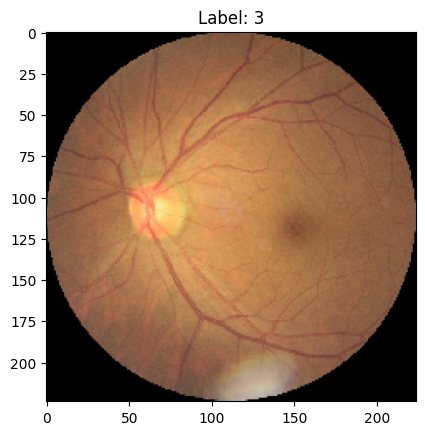

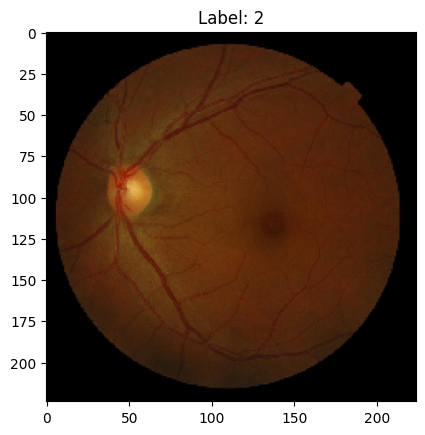

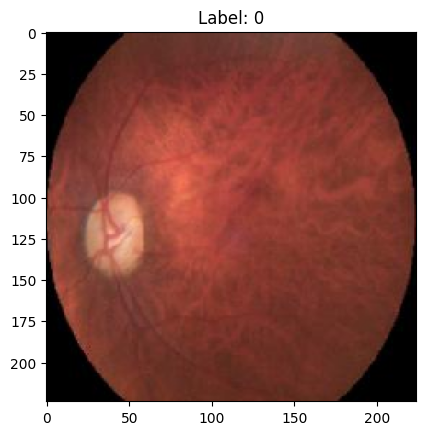

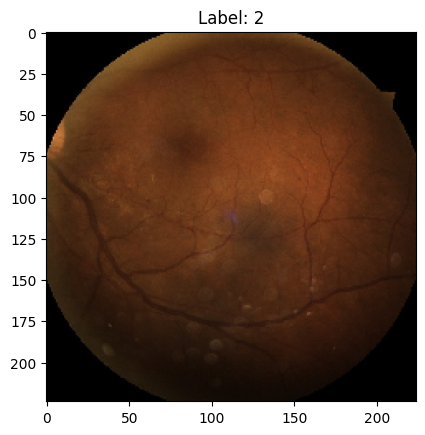

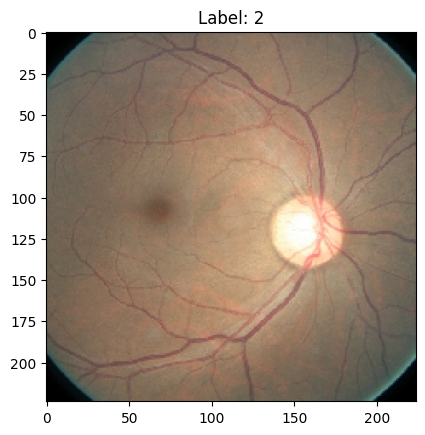

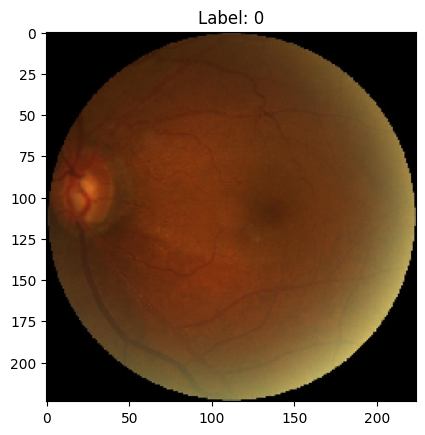

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define target image size (adjust as needed)
target_size = (224, 224)

# Define normalization factors (e.g., scale pixel values to 0-1)
normalization_factor = 1.0 / 255.0  # Assuming pixel values are in the 0-255 range

# Define separate ImageDataGenerator objects for training and validation sets
train_datagen = ImageDataGenerator(rescale=normalization_factor)
validation_datagen = ImageDataGenerator(rescale=normalization_factor)

# Create data generators (flows) for training and validation
train_generator = train_datagen.flow_from_directory(
    directory='dataset/train/',  # Point to the parent folder containing disease subfolders
    target_size=target_size,
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification (adjust if needed)
    classes=['glaucoma', 'cataract', 'diabetic_retinopathy', 'normal'],  # List all disease categories
)

validation_generator = validation_datagen.flow_from_directory(
    directory='dataset/validation/',  # Point to the parent folder containing disease subfolders
    target_size=target_size,
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification (adjust if needed)
    classes=['glaucoma', 'cataract', 'diabetic_retinopathy', 'normal'],  # List all disease categories
)

# Get a few batches from the generators
train_batch_x, train_batch_y = next(train_generator)
validation_batch_x, validation_batch_y = next(train_generator)

# Print the shapes of the data and labels for each batch
print("Train data shape:", train_batch_x.shape)
print("Train labels shape:", train_batch_y.shape)

print("Validation data shape:", validation_batch_x.shape)
print("Validation labels shape:", validation_batch_y.shape)

print("First few training images:", train_batch_x[:3])  # Print only the first 3 images
print("First few training labels (one-hot encoded):", train_batch_y[:3])

print("First few validation images:", validation_batch_x[:5])
print("First few validation labels (one-hot encoded):", validation_batch_y[:5])


import matplotlib.pyplot as plt

# Assuming train_batch_x contains your images
num_images = 10  # Number of images to visualize

for i in range(num_images):
  # Rescale the image (if necessary) from (0-1) to (0-255) for visualization
  image = train_batch_x[i] * 255
  image = image.astype(np.uint8)  # Convert to uint8 for visualization

  plt.imshow(image)
  plt.title(f"Label: {train_batch_y[i].argmax()}")
  plt.show()

### Setting Up The Model

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model


# Define input shape (adjust based on your target image size)
input_shape = (target_size[0], target_size[1], 3)  # Assuming RGB channels

# Load the pre-trained VGG16 model, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers (to avoid retraining them)
vgg16_base.trainable = False  # Set all layers to non-trainable

# Add new classification layers on top of the pre-trained VGG16 base
x = vgg16_base.output  # Output of the pre-trained VGG16 model

# Add a Flatten layer to convert the 3D feature maps to a 1D vector
x = Flatten()(x)

# Add a Dense layer with 1024 units and ReLU activation (adjust units as needed)
x = Dense(1024, activation='relu')(x)

# Add a dropout layer to prevent overfitting (optional, adjust rate as needed)
x = Dropout(0.5)(x)  # Experiment with different dropout rates

# Add the final output layer with the number of classes (4 in your case) and softmax activation
predictions = Dense(4, activation='softmax')(x)

# Create the final model by combining the pre-trained base and new layers
model = Model(inputs=vgg16_base.input, outputs=predictions)

# Print a summary of the model layers and their trainable status
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,409,924 (154.15 MB)

 Trainable params: 25,695,236 (98.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Compiling and Training The Model

In [3]:
# Compile the model
model.compile(optimizer='adam',  # Choose an optimizer (e.g., adam, RMSprop)
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])  # Metrics to monitor training and validation

# Print a summary of the compiled model
model.summary()

# Train the model
model.fit(train_generator,
          validation_data=validation_generator,
          epochs=35,  # Adjust the number of epochs as needed
          steps_per_epoch=None,#len(train_generator),  # Adjust based on your data size (optional)
          validation_steps=None) #len(validation_generator))  # Adjust based on your data size (optional)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,409,924 (154.15 MB)

 Trainable params: 25,695,236 (98.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/35


C:\Users\Dar Laptop\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 740s 9s/step - accuracy: 0.5413 - loss: 4.2607 - val_accuracy: 0.8104 - val_loss: 0.4465
Epoch 2/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 4001s 48s/step - accuracy: 0.8041 - loss: 0.4872 - val_accuracy: 0.8267 - val_loss: 0.4144
Epoch 3/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 698s 8s/step - accuracy: 0.8133 - loss: 0.4570 - val_accuracy: 0.8489 - val_loss: 0.3828
Epoch 4/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 695s 8s/step - accuracy: 0.8308 - loss: 0.4072 - val_accuracy: 0.8444 - val_loss: 0.3861
Epoch 5/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 697s 8s/step - accuracy: 0.8178 - loss: 0.4442 - val_accuracy: 0.8667 - val_loss: 0.3552
Epoch 6/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 704s 8s/step - accuracy: 0.8500 - loss: 0.3904 - val_accuracy: 0.8504 - val_loss: 0.3661
Epoch 7/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 778s 9s/step - accuracy: 0.8424 - loss: 0.3875 - val_accuracy: 0.8563 - val_loss: 0.3773
Epoch 8/35
85/85 ━━━━━━━━━━━━━━━━━━━━ 759s 9s/step - accuracy: 0.8564 - loss: 0.3689 - val_accuracy: 0.8341 - val_loss: 

### Testing the Model

In [4]:
test_datagen = ImageDataGenerator(rescale=normalization_factor)
test_generator = test_datagen.flow_from_directory(
    directory='dataset/test/',  # Point to the parent folder containing disease subfolders
    target_size=target_size,
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification (adjust if needed)
    classes=['glaucoma', 'cataract', 'diabetic_retinopathy', 'normal'],  # List all disease categories
    
)

# Assuming your test data generator is named 'test_datagen'
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

Found 845 images belonging to 4 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.8689 - loss: 0.2925
Test Accuracy: 0.8686390519142151


### Saving The Model

In [5]:
model.save("eye_disease_classifier.h5")
model.save("eye_disease_classifier.keras")